<a href="https://colab.research.google.com/github/HarlinLee/BlobOT/blob/main/small_eps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

import sys
sys.path.insert(0, DRIVE_PATH)

import numpy as np
import matplotlib.pyplot as plt
import torch

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

import pickle

Mounted at /content/drive
230526


In [ ]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
print(device)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

cpu
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from BlobOT import KE, NLE_pos, Model
from BlobOT import draw_straight_lines, EarlyStopping, endpoint_cost, allpoint_cost

def blobLoss(X, model, positive=False):
  ke = KE(X, model.z, model.params)
  nle = NLE_pos(X, model.w, model.params)
  return ke + nle, ke, nle

def training_loop(model, optimizer, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=2, threshold=0,
                                                         factor=0.2)
  early_stopping = EarlyStopping(patience=5)

  losses=[]
  kes = []
  nles = []
  endpoint_costs = []
  allpoint_costs = []

  for i in range(n):
    preds = model()
    loss, ke, nle = blobLoss(preds, model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)

    losses.append(loss.cpu().detach())
    kes.append(ke.cpu().detach())
    nles.append(nle.cpu().detach())

    X = preds.cpu().detach().numpy()
    y = X[:,:,-1]

    c1 = endpoint_cost(y, T(z))
    endpoint_costs.append(c1)

    c2 = allpoint_cost(X, T(z))
    allpoint_costs.append(c2)

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return (np.array(losses), np.array(kes), np.array(nles), 
              np.array(endpoint_costs), np.array(allpoint_costs), res)
    
    if i in [10, 1000, 10000, 100000, n]:
      plt.figure(figsize=(5, 5))
      X = preds.cpu().detach().numpy()
      y = X[:,:,-1]

      # plot particle trajectory
      if X.shape[-1] <= params['L']:
        X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)
      
      t = params['dt']*np.arange(params['L']+1)

      for p in range(X.shape[0]):
        traj = X[p].T
        plt.plot(traj[:, 0], t,  color=[.5, .5, 1])
      
      plt.scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
      plt.scatter(w[:, 0], 1 + np.zeros_like(w[:, 0]), marker='x', c='r', label='Target')
      plt.scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')
      plt.title(f'GD step {i}')
      plt.yticks([0, 1], ['$t$=0', '$t$=1'])
      plt.show()

      res[str(i)] = X

  return (np.array(losses), np.array(kes), np.array(nles), 
              np.array(endpoint_costs), np.array(allpoint_costs), res)


In [ ]:
# load z and w from other experiments

with open(os.path.join(DRIVE_PATH, f'diff_eps_{date}.pkl'), 'rb') as f:
    res = pickle.load(f)

print(res.keys())

params = res['params']

z = res['z']
w = res['w']

dict_keys(['z', 'w', 'params', 'epsilons', '0.1', '1'])


{'d': 1, 'dt': 0.2, 'L': 5, 'n': 1000000, 'N': 20, 'delta': 0.05152052789556263, 'eps': 0.001, 'lr': 1e-05}


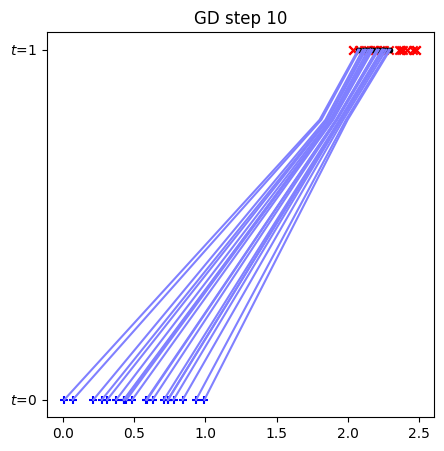

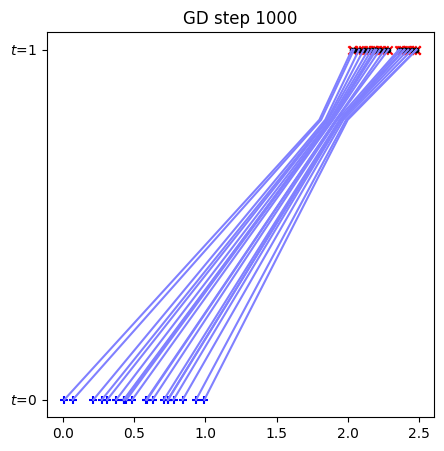

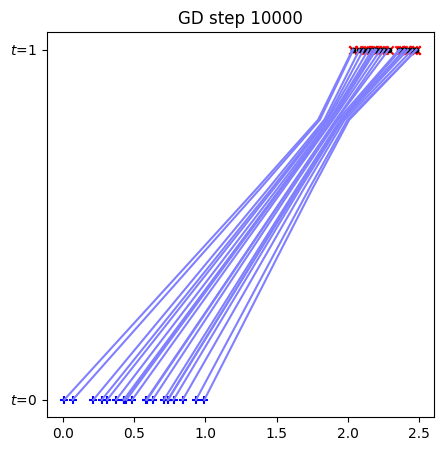

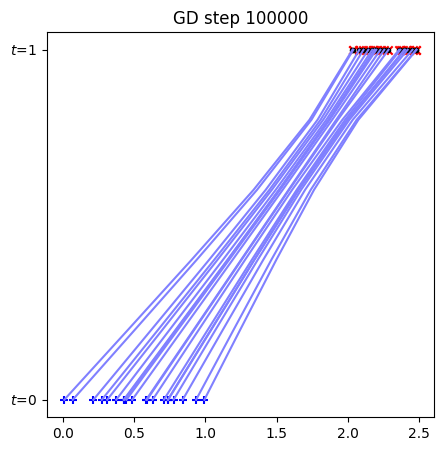

In [ ]:
rng = np.random.RandomState(23)

z_tensor = torch.from_numpy(z).to(device)
w_tensor = torch.from_numpy(w).to(device)

def T(x):
  return 0.5*x + 2

y0 = np.ones((params['N'], params['d']))*(T(0) + T(1))/2 # initialize at 2.25
X0 = draw_straight_lines(z, y0, params['L']+1)

params['eps'] = 0.001
params['lr'] = max(params['eps']/1e3, 1e-5)
params['n'] = int(1e6)

print(params)


# run gradient descent
m = Model(torch.from_numpy(X0), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses, kes, nles, endpoint_costs, allpoint_costs, res1 = training_loop(m, opt, n=params['n'])

X = m.X.data.detach().numpy()

res1['0'] =  np.concatenate((np.expand_dims(z, axis=-1), X0), axis=-1)

with open(os.path.join(DRIVE_PATH, f'small_eps_{date}.npz'), 'wb') as f:
    np.savez(f, losses=losses, kes=kes, nles=nles, endpoint_costs=endpoint_costs, allpoint_costs=allpoint_costs, 
             res1=res1, params=params, w=w, z=z, allow_pickle=True)


# Plotting

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

import sys
sys.path.insert(0, DRIVE_PATH)

import numpy as np
import matplotlib.pyplot as plt
import torch

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)


In [ ]:
with open(os.path.join(DRIVE_PATH, f'small_eps_{date}.npz'), 'rb') as f:
    data = np.load(f, allow_pickle=True)
    print(data.files)
    losses = data['losses']
    kes = data['kes']
    nles = data['nles']
    endpoint_costs = data['endpoint_costs']
    allpoint_costs = data['allpoint_costs']
    res1 = data['res1'][()]
    params = data['params'][()]
    w = data['w']
    z = data['z']


In [ ]:
t = params['dt']*np.arange(params['L']+1)
dt = params['dt']
ns = [0, 10, int(1e5), int(1e6)]

fig, ax = plt.subplots(2, 2, figsize=(5*2, 5*2))

for i, k in enumerate(ns):
  X = res1[str(k)]
  y = X[:, :, -1]
  
  col = i % 2
  row = i // 2

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[row, col].plot(traj[:, 0], t,  color=[.5, .5, 1])

  ax[row, col].scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
  ax[row, col].scatter(w[:, 0], 1 + np.zeros_like(w[:, 0]), marker='x', c='r', label='Target')
  ax[row, col].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')
  if k < 100:
    ax[row, col].set_title(f"GD step {k}", fontsize=20)
  else:
    ax[row, col].set_title(f"GD step $10^{int(np.log10(k))}$", fontsize=20)
  ax[row, col].set_yticks([0, 1], ['$t$=0', '$t$=1'], fontsize=16)
  ax[row, col].xaxis.set_tick_params(labelsize=16) 

  if i ==0:
    ax[row, col].legend(fontsize=14, markerscale=2)
  
  if i != 2:
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
  else:
    ax[row, col].set_xlabel('1 dimensional $x(t)$', fontsize=16)


# share x, y axis
ylims = np.array([a.get_ylim() for a in ax.ravel()])
xlims = np.array([a.get_xlim() for a in ax.ravel()])
for cell in ax.ravel():
  cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
  cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))

plt.tight_layout(pad=0)
plt.savefig(os.path.join(DRIVE_PATH, f'small_eps_{date}_no_zoom.pdf'), dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))

steps = range(1, int(len(kes))+1)
shifted = True

const_term1 = kes.min()-nles.min()

if shifted:
  ax[0].plot(steps, losses-const_term1, linewidth=3, label=r'Total loss$^*$')
  ax[0].plot(steps, kes-const_term1, linestyle='--', linewidth=3, label = r'Kinetic energy$^*$')
else:
  ax[0].plot(steps, losses, linewidth=3, label=r'Total loss')
  ax[0].plot(steps, kes, linestyle='--', linewidth=3, label = r'Kinetic energy')

ax[0].plot(steps, nles, linestyle='-.', linewidth=3, label='Non-local energy')

ns = [1, 10, int(1e5), int(1e6)]

for n in ns:
  ax[0].vlines(n, ymin=2*1e-5, ymax=1e5, colors='k', linestyles='dotted')

ax[0].set_xscale('log')
ax[0].set_yscale('log')

# plot error wrt OT map

ax[1].plot(steps, endpoint_costs, linewidth=3, label=r'At $t=1$')
ax[1].plot(steps, allpoint_costs, linestyle='--', linewidth=3, label = 'At all time points')
for n in ns:
  ax[1].vlines(n, ymin=0.04, ymax=0.22, colors='k', linestyles='dotted')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

# labeling things in the plot
kwarg = dict(fontsize=24)
leg_kwarg = dict(fontsize=16, markerscale=2)
tick_kwarg = dict(labelsize=16)

ax[0].xaxis.set_tick_params(**tick_kwarg)
ax[1].xaxis.set_tick_params(**tick_kwarg)

ax[0].yaxis.set_tick_params(**tick_kwarg)
ax[1].yaxis.set_tick_params(**tick_kwarg)

ax[0].set_xlabel('Gradient descent steps', fontsize=16)
ax[1].set_xlabel('Gradient descent steps', fontsize=16)

ax[0].set_title('Objective function value', **kwarg)
ax[1].set_title('Error from OT map', **kwarg)

ax[0].legend(**leg_kwarg) 
ax[1].legend(**leg_kwarg)

ax[1].set_yticks([0.04, 0.06, 0.1, 0.2], [0.04, 0.06, 0.1, 0.2])

plt.tight_layout(pad=0)
plt.savefig(os.path.join(DRIVE_PATH, f'small_eps_{date}_loss.pdf'), dpi=300)
plt.show()
